# Data processing and exploration
This notebook is meant for procesing and exploring the retrieved Sentinel-2 imagery. The preprocessing stage consists of : ..

The exploration of the satellite imagery will involve

! Important to note: This notebook was tested only in Colab enviroment.

In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 98.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import tarfile
import json
import os
import geopandas as gpd
import rasterio
from rasterio import mask
from rasterio.plot import show
import numpy as np
import cv2
from PIL import Image as im
import pandas as pd
import seaborn as sns
import ast
import datetime
from skimage.exposure import match_histograms
from datetime import date

In [ ]:
input_lyme_regis_path = "/content/drive/MyDrive/FINAL_project/full_lyme_regis_S2_L1C"

input_lst = []

for root, dirs, files in os.walk(input_lyme_regis_path):
  for dir in dirs:
    if dir.startswith("response_"):
      full_path = os.path.join(root, dir)
      input_dict = {}
      for f in os.listdir(full_path):
        if f.startswith("default"):
            ### Import the image
            full_path2 = os.path.join(full_path, f)

            with rasterio.open(full_path2) as src:
                arr = src.read()
                temp_img = np.moveaxis(arr, 0, -1)
                input_dict.setdefault("default.tif", temp_img)

        elif f.startswith("userdata"):
            ### Import the metadata
            full_path2 = os.path.join(full_path, f)
            with open(full_path2) as user_file:
                file_contents = user_file.read()
            parsed_json = json.loads(file_contents)
            input_dict.setdefault("userdata.json", parsed_json)
      input_lst.append(input_dict)

In [ ]:
# Check if the downloaded data is the same length as the unique dates
print("Retrieved number of imagery: ", len(input_lst))

# Find the keys of dictionary
print("Dictionary keys: ", input_lst[1].keys())
print("Sample information about the satellite imagery: ",input_lst[1]["userdata.json"])
scene_info = ast.literal_eval(input_lst[1]["userdata.json"]["scenes"])


##  Retrieve important parameters from each image
all_info = []

for data in input_lst:
    # Filter out any images that have a probablity of clouds in the tile
    if 1 not in data["default.tif"][:, :, [5]]:
      img_info = []

      scene_info = ast.literal_eval(data["userdata.json"]["scenes"])

      img_info.append(datetime.datetime.strptime(scene_info[0]["date"],"%Y-%m-%dT%H:%M:%S.%fZ"))
      img_info.append(scene_info[0]["productId"])
      img_info.append(len(scene_info))
      img_info.append(data["userdata.json"]["norm_factor"])

      img_info.append(data["default.tif"])
      img_info.append(data["default.tif"][:,:,0])
      img_info.append(data["default.tif"][:,:,1])
      img_info.append(data["default.tif"][:,:,2])
      img_info.append(data["default.tif"][:,:,3])
      img_info.append(data["default.tif"][:,:,4])

      all_info.append(img_info)

print("Final number of imagery available: ", len(all_info))

Retrieved number of imagery:  153
Dictionary keys:  dict_keys(['userdata.json', 'default.tif'])
Sample information about the satellite imagery:  {'norm_factor': 0.0001, 'scenes': '[{"date":"2022-03-22T11:17:08.000Z","tileId":20262270,"tileOriginalId":"S2B_OPER_MSI_L1C_TL_VGS4_20220322T121416_A026332_T30UVB_N04.00","productId":"S2B_MSIL1C_20220322T110639_N0400_R137_T30UVB_20220322T121416","__idx":0,"bandBuffers":[{},{},{},{},{},{}]},{"date":"2022-03-22T11:17:04.000Z","tileId":20262455,"tileOriginalId":"S2B_OPER_MSI_L1C_TL_VGS4_20220322T121416_A026332_T30UWB_N04.00","productId":"S2B_MSIL1C_20220322T110639_N0400_R137_T30UWB_20220322T121416","__idx":1,"bandBuffers":[{},{},{},{},{},{}]}]'}
Final number of imagery available:  99


In [ ]:
# Creating dataframe with all the information
lyme_regis_df = pd.DataFrame(all_info, columns=["date", "productID", "num_img", "norm_factor", "all_bands", "B2", "B3", "B4", "B8", "B11"])

# Sorting the dateframe based on the retrieval date
sorted_lyme_regis_df = lyme_regis_df.sort_values(by=['date'])
sorted_lyme_regis_df.reset_index(drop=True, inplace=True)

print(sorted_lyme_regis_df.head())

                 date                                          productID  \
0 2015-09-10 11:16:33  S2A_OPER_PRD_MSIL1C_PDMC_20160720T165432_R137_...   
1 2015-09-30 11:11:02  S2A_OPER_PRD_MSIL1C_PDMC_20161103T183715_R137_...   
2 2015-10-20 11:11:03  S2A_OPER_PRD_MSIL1C_PDMC_20161210T214034_R137_...   
3 2016-07-19 11:21:17  S2A_OPER_PRD_MSIL1C_PDMC_20160719T185327_R037_...   
4 2016-08-15 11:08:03  S2A_OPER_PRD_MSIL1C_PDMC_20160815T205931_R137_...   

   num_img  norm_factor                                          all_bands  \
0        2       0.0001  [[[1042, 1014, 626, 3802, 2024, 0], [1012, 961...   
1        2       0.0001  [[[1076, 1044, 606, 4378, 2055, 0], [1038, 988...   
2        2       0.0001  [[[1057, 955, 500, 4570, 1827, 0], [1043, 878,...   
3        2       0.0001  [[[852, 854, 446, 4918, 1883, 0], [857, 852, 4...   
4        2       0.0001  [[[1057, 1074, 748, 4074, 2186, 0], [1035, 105...   

                                                  B2  \
0  [[1042, 1012, 1

In [ ]:
ncols, nrows = 2, 5

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 45), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx in range(10):

    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(sorted_lyme_regis_df["all_bands"][idx][:, :, [2,1,0]]*(3.5*0.0001), 0, 1))
    ax.set_title(sorted_lyme_regis_df["date"][idx], fontsize=10)

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

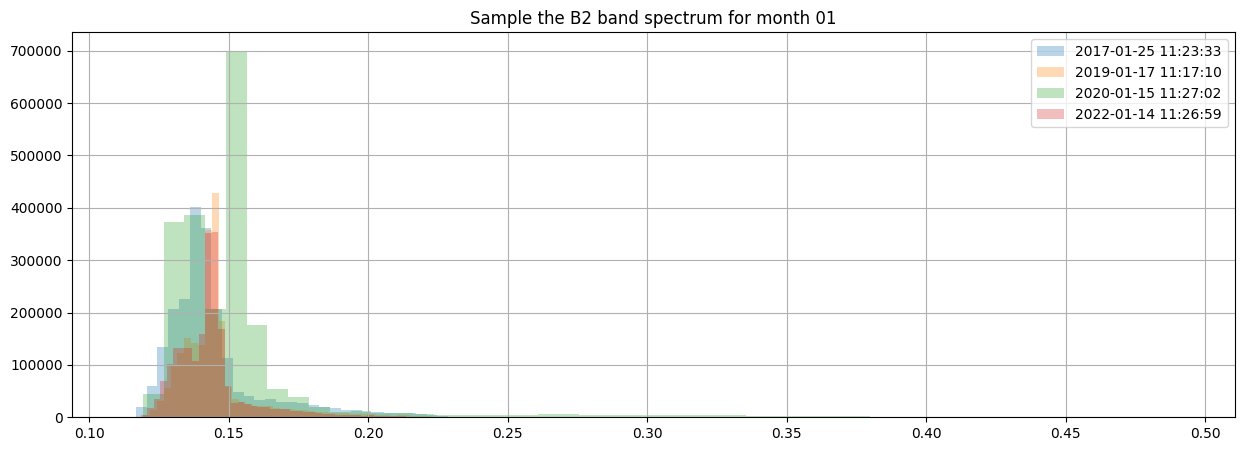

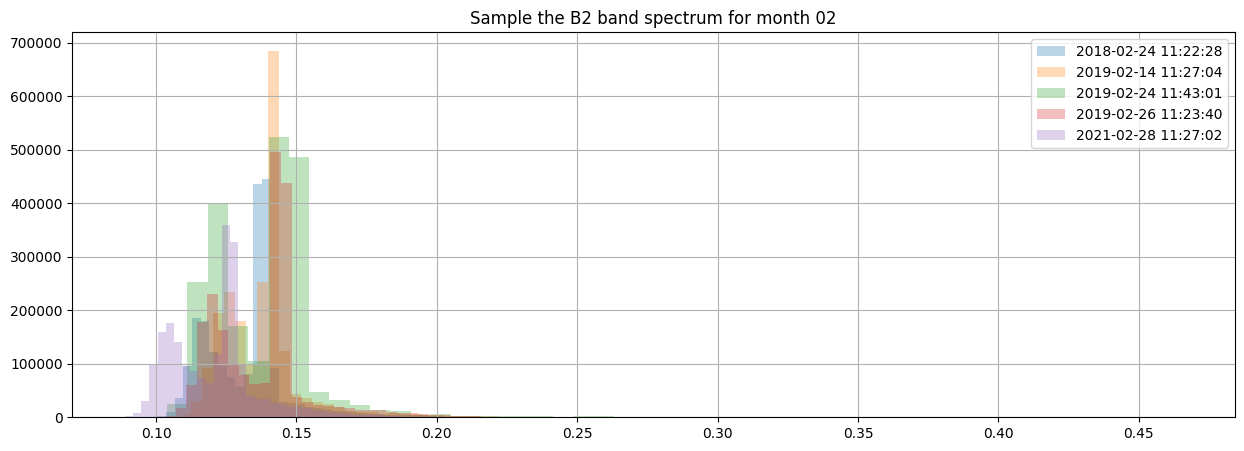

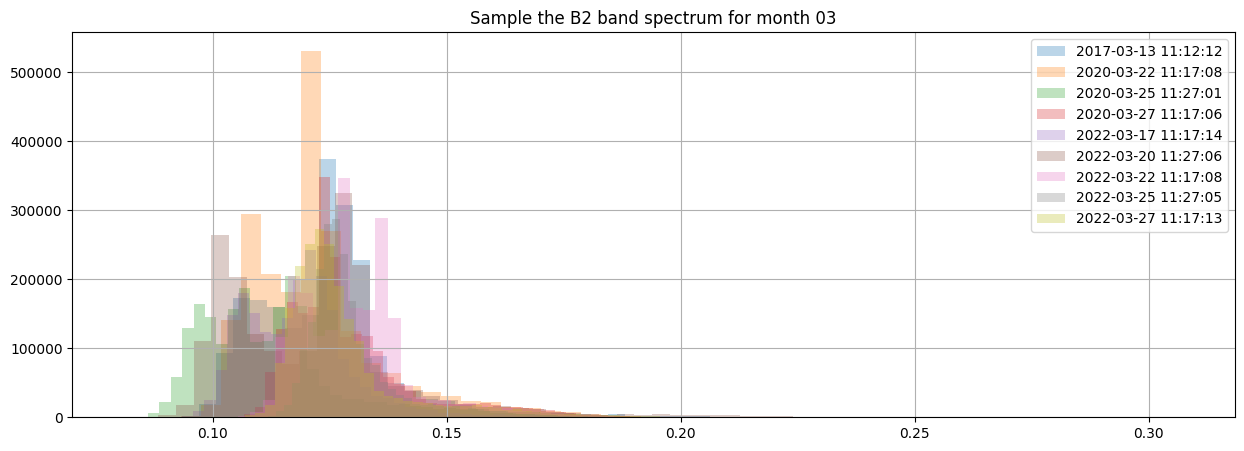

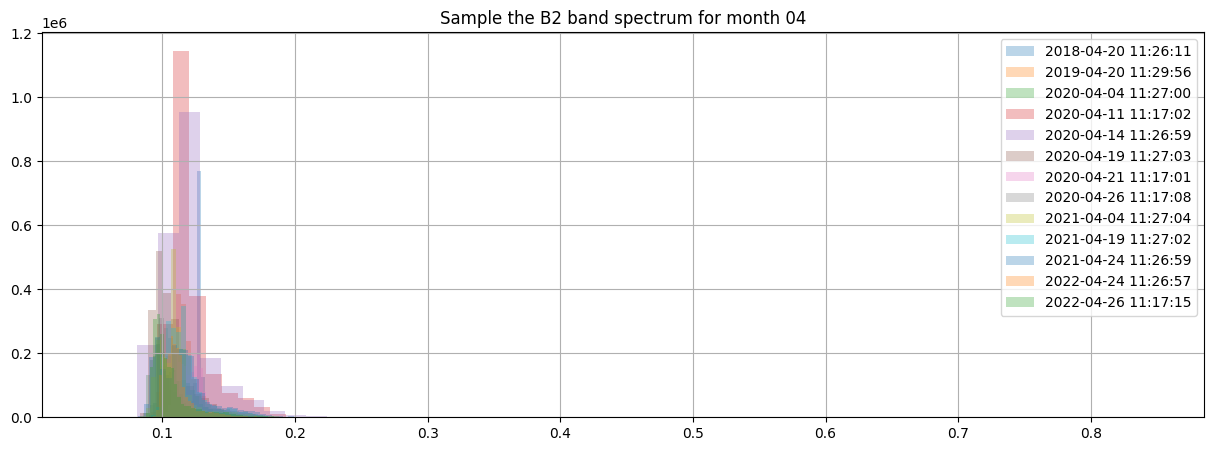

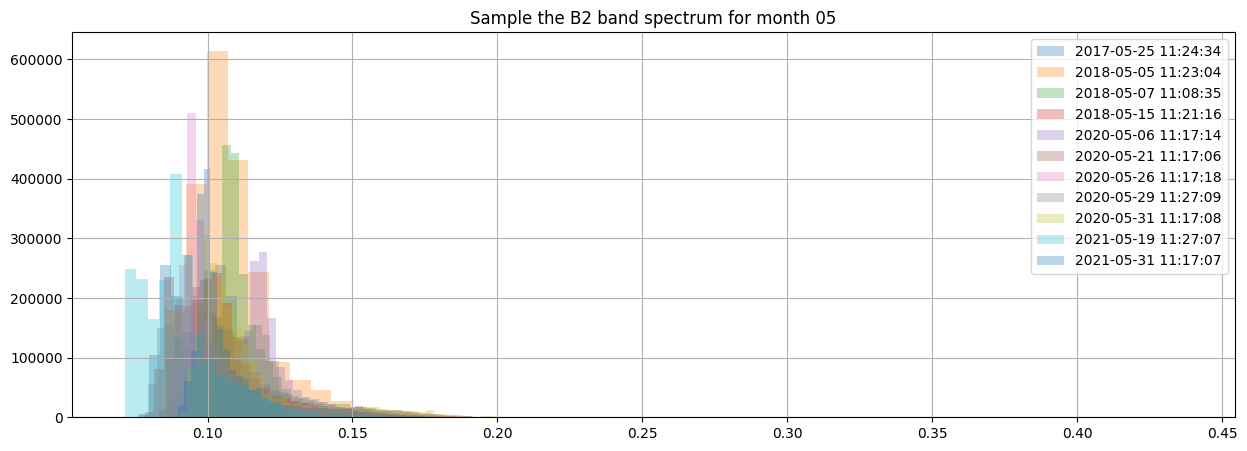

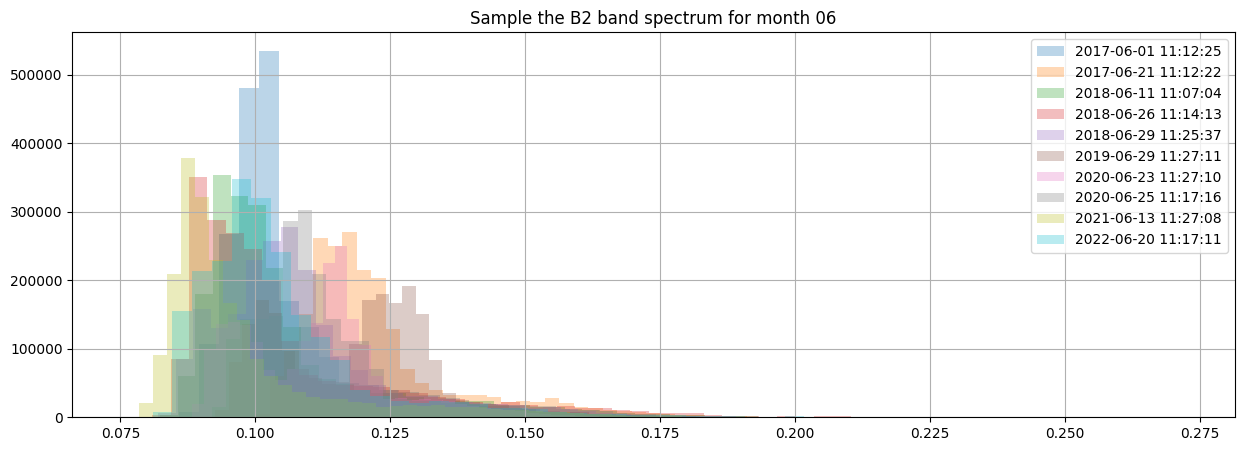

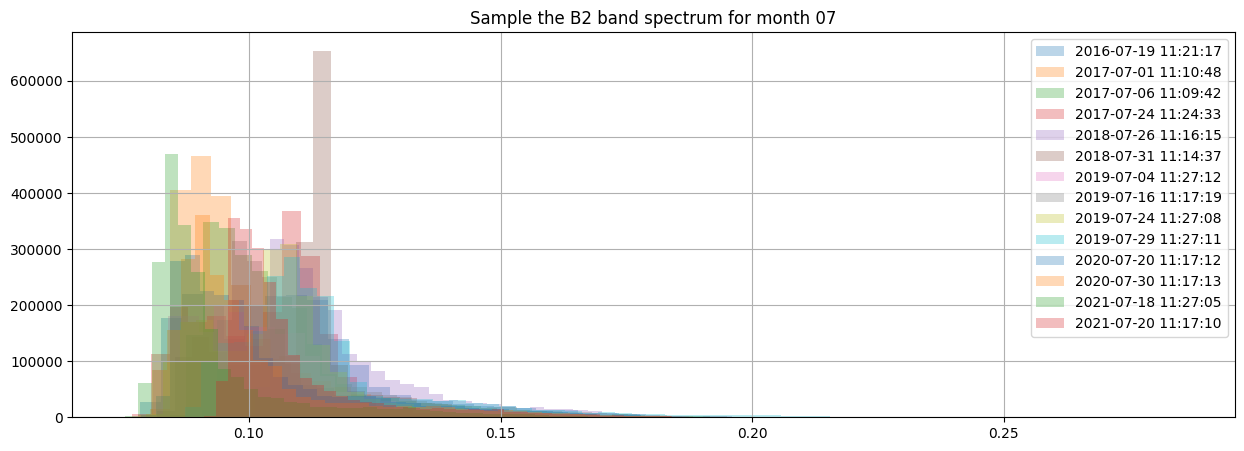

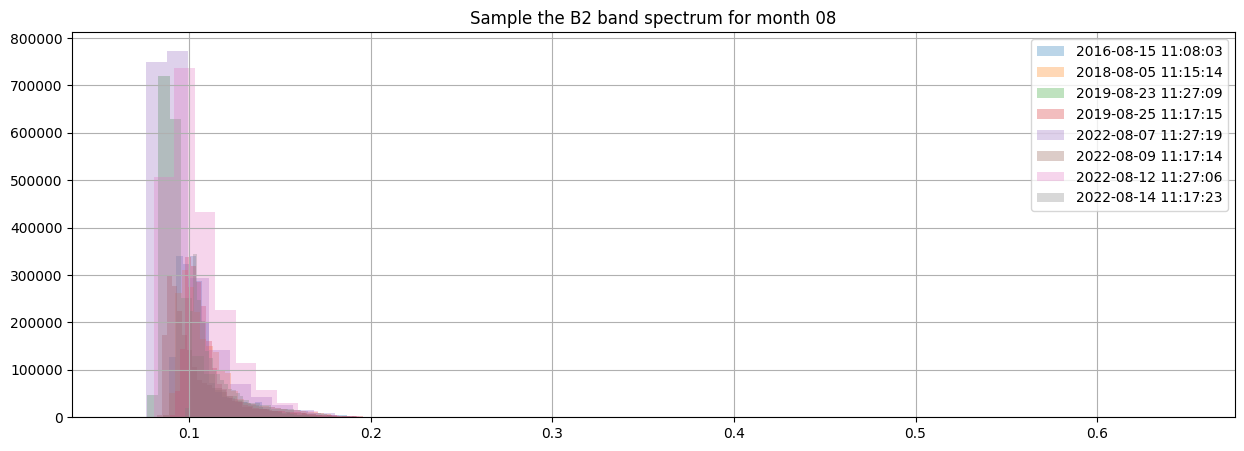

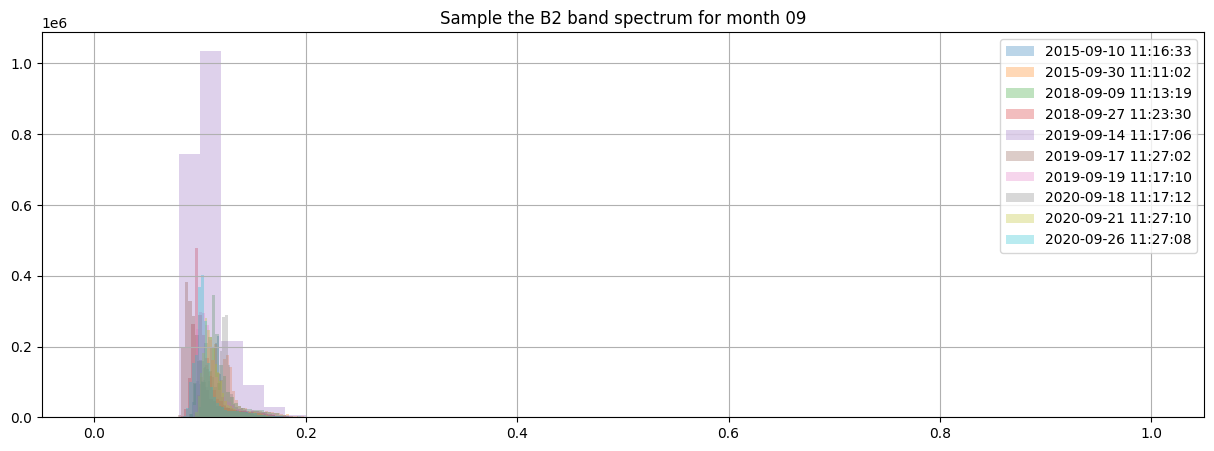

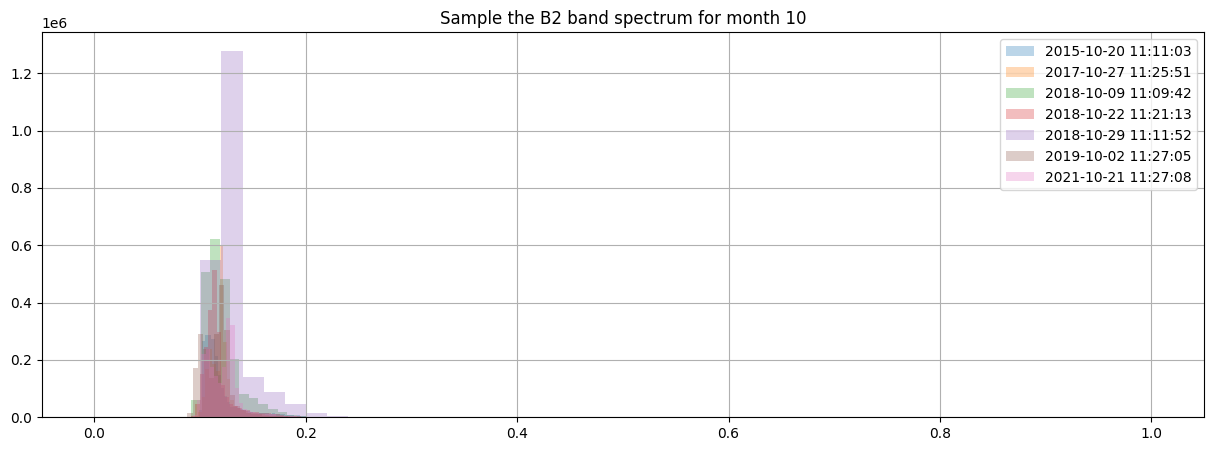

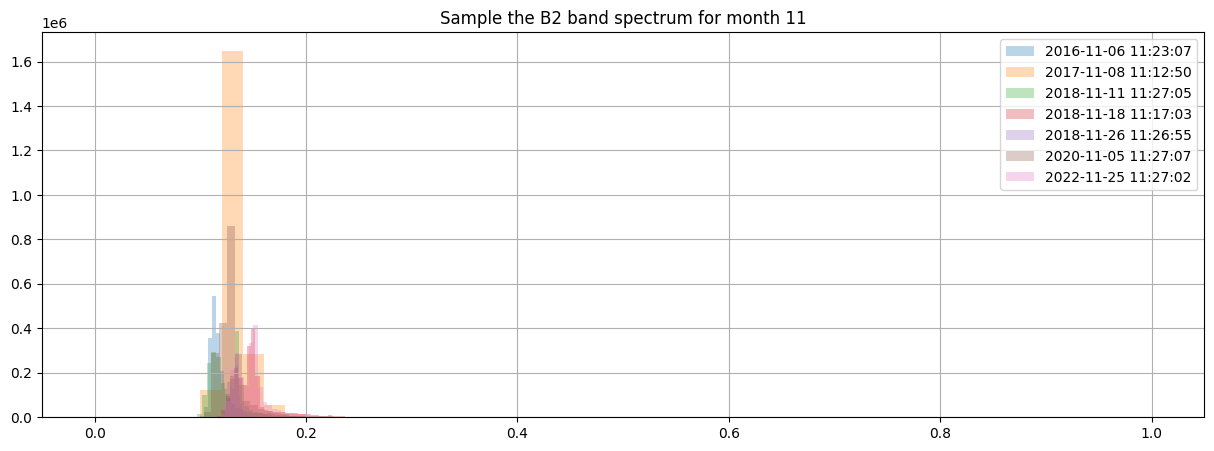

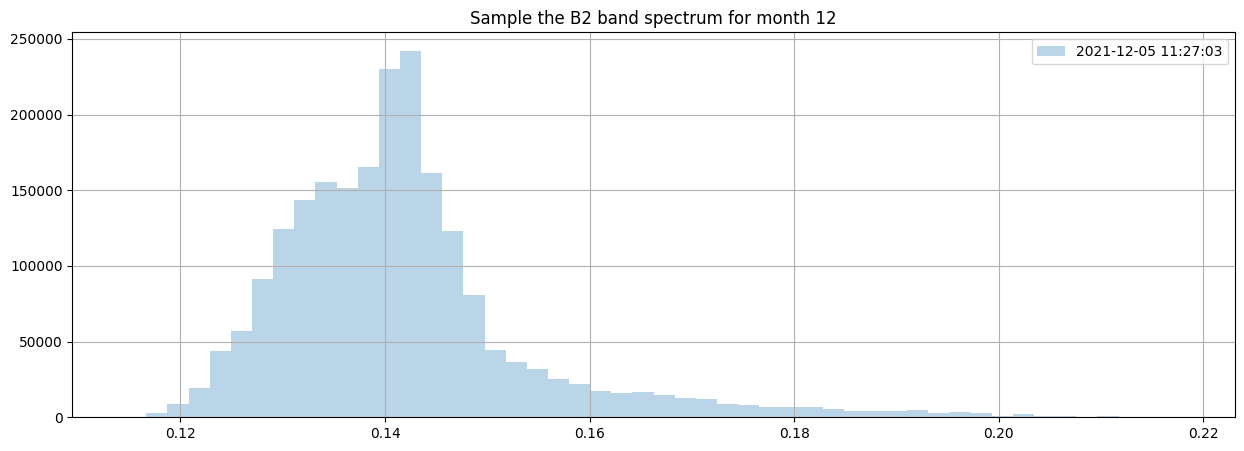

In [ ]:
# Filter for specific single month for each year
month_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for m in month_lst:
  df2 = sorted_lyme_regis_df[sorted_lyme_regis_df['date'].dt.strftime('%m') == m]
  # Possible other bands to explore - B2, B3, B4, B8 and B11
  band_id = "B2"
  _, ax = plt.subplots(figsize=(15, 5))

  for i, rows in df2.iterrows():
    plt.hist(np.clip(rows[band_id].flatten()*0.0001,0,1), bins=50, label=f"{rows['date']}", alpha=0.3)

  ax.grid("on")
  ax.legend()
  plt.title(f"Sample the {band_id} band spectrum for month {m}")
  plt.show()

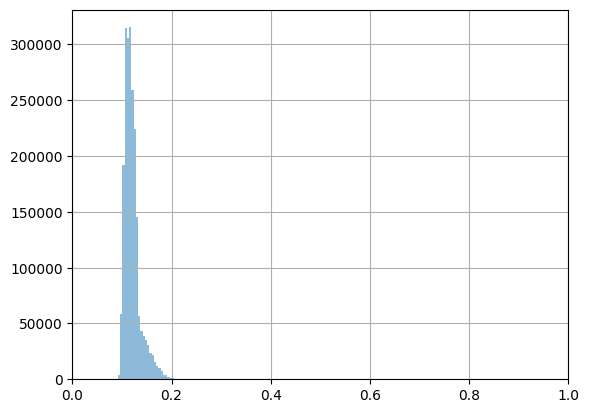

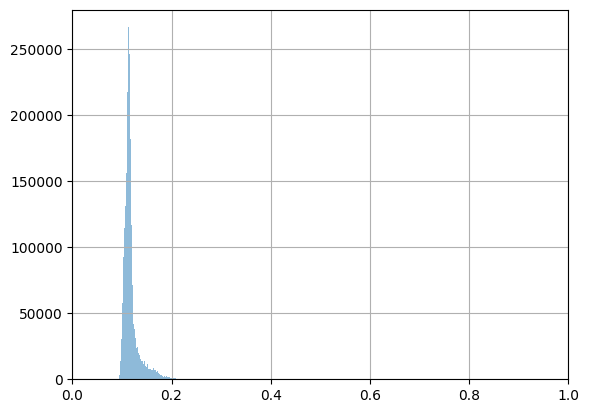

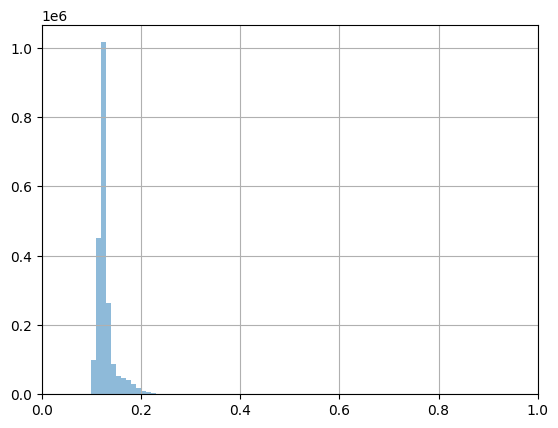

In [ ]:
# Filter for specific month and specific year
df2 = sorted_lyme_regis_df[sorted_lyme_regis_df['date'].dt.strftime('%Y-%m') == '2018-10']
# Possible other bands to explore - B2, B3, B4, B8 and B11
band_id = "B2"
# Compare pixel distribution for a specific band captured around the same time span
for i, rows in df2.iterrows():
  plt.figure()
  plt.hist(np.clip(rows[band_id].flatten()*0.0001,0,1), bins=100, label=f"{band_id} band, idx={i}", alpha=0.5)
  plt.xlim(0,1)
  plt.grid()
  plt.show()

In [ ]:
# Iterate through the dateframe and normalize the individual bands between 0 and 1
## Take the mean value for each image of each band

def create_stats_df(full_df):
    stats_lst = []
    for i, row in full_df.iterrows():
        stats_lst.append([row['date'],np.clip(row["B2"]*0.0001,0,1).mean(), np.clip(row["B3"]*0.0001,0,1).mean(), np.clip(row["B4"]*0.0001,0,1).mean(), np.clip(row["B8"]*0.0001,0,1).mean(), np.clip(row["B11"]*0.0001,0,1).mean()])

    # Create a dataframe
    comp_df = pd.DataFrame(stats_lst, columns=['date', "B2", "B3", "B4", "B8", "B11"])

    return comp_df


In [ ]:
stats_df = create_stats_df(sorted_lyme_regis_df)
stats_df.head()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


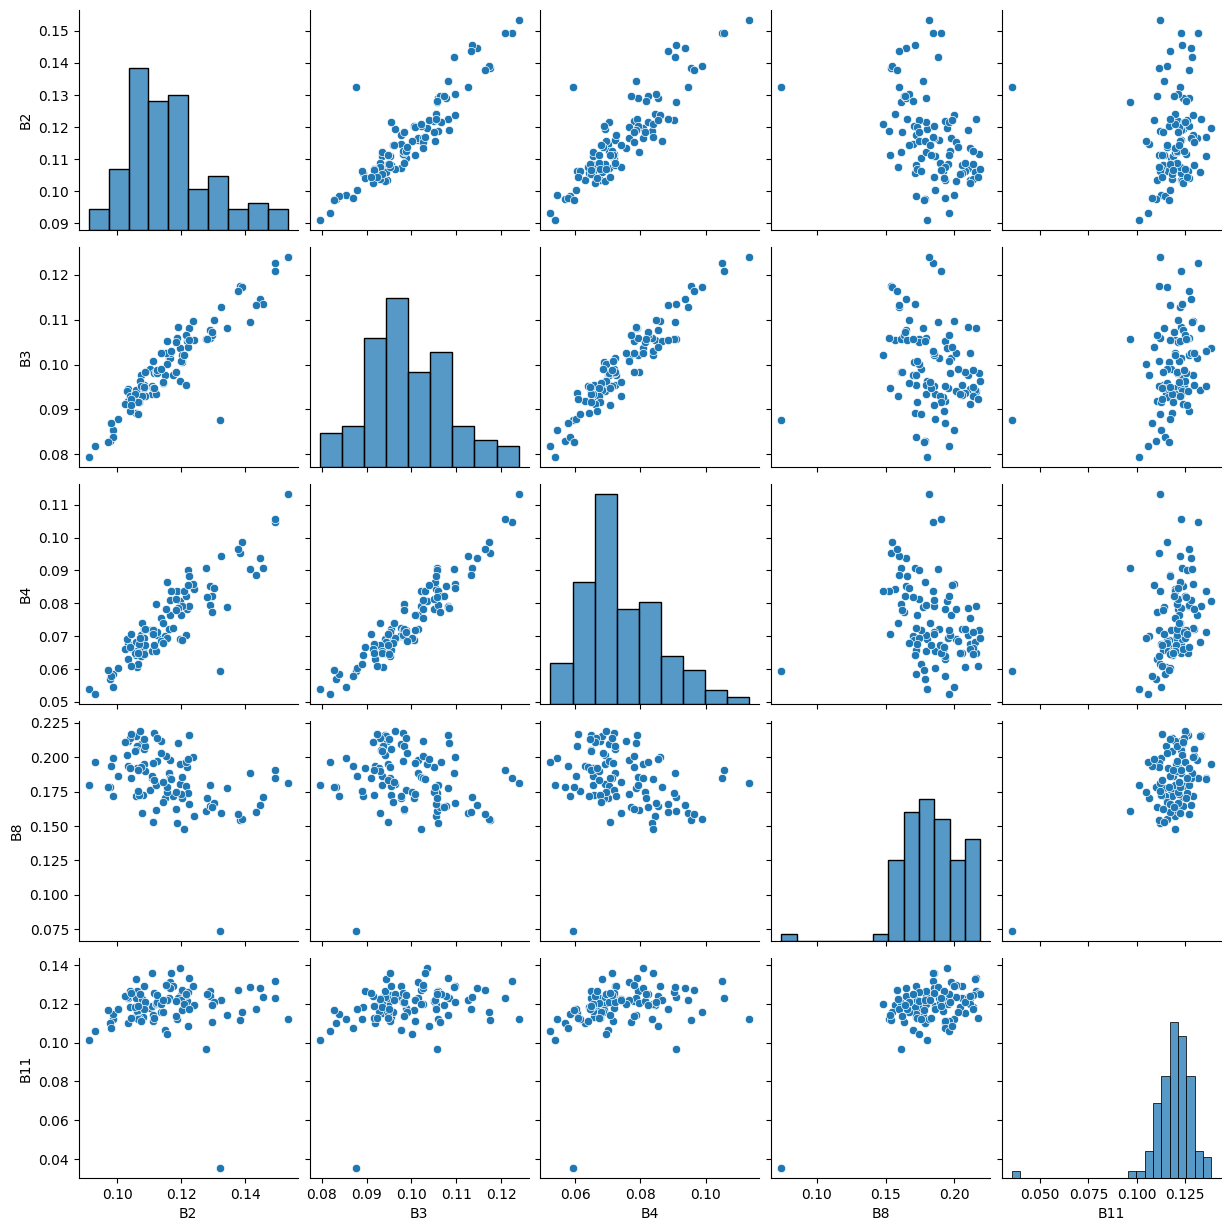

In [ ]:
## Explore the new statistical dataframe
sns.pairplot(stats_df, size=2.5)

In [ ]:
# Find the overview of the statistical dataframe
stats_df.describe()

,B2,B3,B4,B8,B11
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,0.116354,0.099504,0.074639,0.184050,0.119090
std,0.013106,0.009067,0.011897,0.021446,0.011386
min,0.091162,0.079492,0.052459,0.073934,0.035561
25%,0.106845,0.093415,0.066151,0.171515,0.114430
50%,0.114321,0.098335,0.071759,0.184873,0.120231
75%,0.122163,0.105632,0.082015,0.198422,0.124755
max,0.153372,0.123938,0.113320,0.219133,0.138477


In [ ]:
## Obtain the two indeces - NDVI and NDMI and add to the dataframe
ndvi_index = []
moisture_index = []

for i,row in sorted_lyme_regis_df.iterrows():
    ndvi = (row["B8"]-row["B4"])/(row["B8"]+row["B4"])
    ndmi = (row["B8"]-row["B11"])/(row["B8"]+row["B11"])
    ndvi_index.append([np.mean(ndvi), np.std(ndvi)])
    moisture_index.append([np.mean(ndmi), np.std(ndmi)])

stats_df[["ndvi", "std_ndvi"]] = ndvi_index
stats_df[["ndmi", "std_ndmi"]] = moisture_index

In [ ]:
stats_df

,date,B2,B3,B4,B8,B11,ndvi,std_ndvi,ndmi,std_ndmi
0,2015-09-10 11:16:33,0.114843,0.097734,0.070107,0.170264,0.106524,0.193457,0.426114,0.368022,0.224672
1,2015-09-30 11:11:02,0.122018,0.105130,0.078121,0.193204,0.121290,0.188480,0.446172,0.384282,0.244418
2,2015-10-20 11:11:03,0.119522,0.096270,0.069142,0.180449,0.124107,0.191764,0.404846,0.337648,0.235402
3,2016-07-19 11:21:17,0.107362,0.097701,0.070241,0.209784,0.123512,0.268693,0.419935,0.284116,0.143144
4,2016-08-15 11:08:03,0.108550,0.094800,0.069281,0.195354,0.120136,0.246470,0.393790,0.282593,0.130697
...,...,...,...,...,...,...,...,...,...,...
94,2022-08-07 11:27:19,0.097186,0.082689,0.059791,0.178012,0.116542,0.226901,0.412192,0.292550,0.181115
95,2022-08-09 11:17:14,0.104202,0.089707,0.066577,0.192404,0.126795,0.213317,0.424686,0.319880,0.215755
96,2022-08-12 11:27:06,0.104471,0.091005,0.070698,0.185033,0.125790,0.222778,0.398573,0.299254,0.210990
97,2022-08-14 11:17:23,0.114355,0.096067,0.074079,0.182306,0.122094,0.225356,0.347777,0.296566,0.182164


In [ ]:
## Resample the dataset to give a timeseries of quaterly statisitcs
data_month = stats_df.resample('Q', on='date').mean()
print(data_month.head())
print(data_month.describe())

                  B2        B3        B4        B8       B11      ndvi  \
date                                                                     
2015-09-30  0.118431  0.101432  0.074114  0.181734  0.113907  0.190968   
2015-12-31  0.119522  0.096270  0.069142  0.180449  0.124107  0.191764   
2016-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2016-06-30       NaN       NaN       NaN       NaN       NaN       NaN   
2016-09-30  0.107956  0.096251  0.069761  0.202569  0.121824  0.257581   

            std_ndvi      ndmi  std_ndmi  
date                                      
2015-09-30  0.436143  0.376152  0.234545  
2015-12-31  0.404846  0.337648  0.235402  
2016-03-31       NaN       NaN       NaN  
2016-06-30       NaN       NaN       NaN  
2016-09-30  0.406862  0.283355  0.136920  
              B2         B3         B4         B8        B11       ndvi  \
count  28.000000  28.000000  28.000000  28.000000  28.000000  28.000000   
mean    0.119243   0.101006   

In [ ]:
def plot_band_statistics(data_df, save_flag=False, output_path="./"):

    bands = ["B2", "B3", "B4", "B8", "B11"]
    color = ['tab:blue', 'tab:green', 'tab:red', 'tab:cyan', 'tab:pink']
    _, axs = plt.subplots()

    for i, b in enumerate(bands):
        axs.plot(list(data_df.index), data_df[b], "-o", c=color[i], label=b)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Mean pixel value for each band quaterly")
    plt.grid(True, which='major')
    if save_flag:
      plt.savefig(os.path.join(output_path, "mean_pixel_each_band_L1C.png"))
    plt.show()

In [ ]:
plot_band_statistics(data_month)

In [ ]:
def plot_index_stats(data_df, indeces_id, save_flag=False, sat_type="L1C", output_path="./"):
    plt.figure()
    plt.plot(list(data_df.index), data_df[indeces_id], "-o", label=f"Mean {indeces_id}")
    if f"std_{indeces_id}" in data_df.columns:
        plt.fill_between(list(data_df.index), data_df[indeces_id] - data_df[f"std_{indeces_id}"], data_df[indeces_id] + data_df[f"std_{indeces_id}"], alpha=0.2)
    plt.xticks(list(data_df.index), minor=True)

    plt.grid()
    plt.title(f"Mean {indeces_id.upper()} value on quaterly bases")
    plt.legend()
    if save_flag:
        plt.savefig(os.path.join(output_path, f"mean_{indeces_id}_{sat_type}.png"))
    plt.show()

In [ ]:
plot_index_stats(data_month, "ndvi")
plot_index_stats(data_month, "ndmi")

In [ ]:
#### MASKING THE SATELLITE IMAGERY

## Import the polygon covering the specific area of interest in Lyme Regis
mask_path = "/content/drive/MyDrive/FINAL_project/lyme_ridges_AOI.geojson"
geo = gpd.read_file(mask_path)

## Fetch the data to mask the images
input_lyme_regis_path = "/content/drive/MyDrive/FINAL_project/full_lyme_regis_S2_L1C"

## Output path to were the masked tif files are saved to for L1C imagery
masked_tif_path = "/content/drive/MyDrive/FINAL_project/masked_L1C_tiff"

input_lst = []

## Iterate through the raw files to apply the mask and save the processed result
for root, dirs, files in os.walk(input_lyme_regis_path):
  for dir in dirs:
    if dir.startswith("response_"):
      full_path = os.path.join(root, dir)
      input_dict = {}
      for f in os.listdir(full_path):
        if f.startswith("default"):
            ### Import the image
            full_path2 = os.path.join(full_path, f)

            with rasterio.open(full_path2) as src:
                ### Check that the crs for both file match
                ### If not, adjust the polygon to match the imagery
                if src.crs != geo.crs:
                    geo = geo.to_crs(src.crs)

                ## Apply the mask
                out_image, out_transform = rasterio.mask.mask(src, geo.geometry)
                ## Save the output result as a tif file
                profile = src.profile.copy()
                profile.update(count = 6)
                profile.update(crs = 'EPSG:4326')
                profile["height"] = out_image.shape[1]
                profile["width"] = out_image.shape[2]
                profile["transform"] = out_transform

                with rasterio.open(fp=os.path.join(masked_tif_path, f"{dir}.tif"), mode='w',**profile) as dst:
                      dst.write(out_image, [1,2,3,4,5,6])

EPSG:4326


In [ ]:
masked_tiff_path = "/content/drive/MyDrive/FINAL_project/masked_L1C_tiff"
original_s2_path = "/content/drive/MyDrive/FINAL_project/full_lyme_regis_S2_L1C"

masked_input_lst = []
## Iterating through the folder path and linking meta data to the file
for f in os.listdir(masked_tiff_path):
    file_info = []
    full_path = os.path.join(masked_tiff_path, f)
    id = f.rsplit("_", 1)[1].rsplit(".", 1)[0]
    # Find the meta data based on the naming pattern
    user_data_path = os.path.join(original_s2_path, id, f"response_{id}", "userdata.json")
    if os.path.isfile(user_data_path):
        with open(user_data_path) as user_file:
            file_contents = user_file.read()
        parsed_json = json.loads(file_contents)

        scene_info = ast.literal_eval(parsed_json["scenes"])
        # Compile the information
        file_info.append(datetime.datetime.strptime(scene_info[0]["date"],"%Y-%m-%dT%H:%M:%S.%fZ"))
        file_info.append(scene_info[0]["productId"])

    else:
        print(f"Cant find the following tile ID {id} in the directory of {original_s2_path}")
        break
    # Extract the imagery data
    with rasterio.open(full_path) as src:
        data = src.read()
        temp_data = np.moveaxis(data, 0, -1)
    # Compile the information
    file_info.append(temp_data[:,:,[0,1,2,3,4]])
    file_info.append(temp_data[:,:,0])
    file_info.append(temp_data[:,:,1])
    file_info.append(temp_data[:,:,2])
    file_info.append(temp_data[:,:,3])
    file_info.append(temp_data[:,:,4])

    file_info.append(len(np.unique(temp_data[:,:,5])) == 1)

    masked_input_lst.append(file_info)

In [ ]:
masked_df = pd.DataFrame(masked_input_lst, columns=["date", "productID", "all_bands", "B2", "B3", "B4", "B8", "B11", "CLM"])

# Sorting the dateframe based on the retrieval date
masked_df = masked_df.sort_values(by=['date'])
masked_df = masked_df.loc[masked_df['CLM'] == True]
masked_df.reset_index(drop=True, inplace=True)

print(masked_df.head())
#masked_df.to_csv("/content/drive/MyDrive/FINAL_project/masked_dataset_L1C.csv")

                 date                                          productID  \
0 2015-09-10 11:16:33  S2A_OPER_PRD_MSIL1C_PDMC_20160720T165432_R137_...   
1 2015-09-30 11:11:02  S2A_OPER_PRD_MSIL1C_PDMC_20161103T183715_R137_...   
2 2015-10-20 11:11:03  S2A_OPER_PRD_MSIL1C_PDMC_20161210T214034_R137_...   
3 2016-07-19 11:21:17  S2A_OPER_PRD_MSIL1C_PDMC_20160719T185327_R037_...   
4 2016-08-15 11:08:03  S2A_OPER_PRD_MSIL1C_PDMC_20160815T205931_R137_...   

                                           all_bands  \
0  [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...   
1  [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...   
2  [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...   
3  [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...   
4  [[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, ...   

                                                  B2  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(masked_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       106 non-null    datetime64[ns]
 1   productID  106 non-null    object        
 2   all_bands  106 non-null    object        
 3   B2         106 non-null    object        
 4   B3         106 non-null    object        
 5   B4         106 non-null    object        
 6   B8         106 non-null    object        
 7   B11        106 non-null    object        
 8   CLM        106 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(7)
memory usage: 6.9+ KB
None


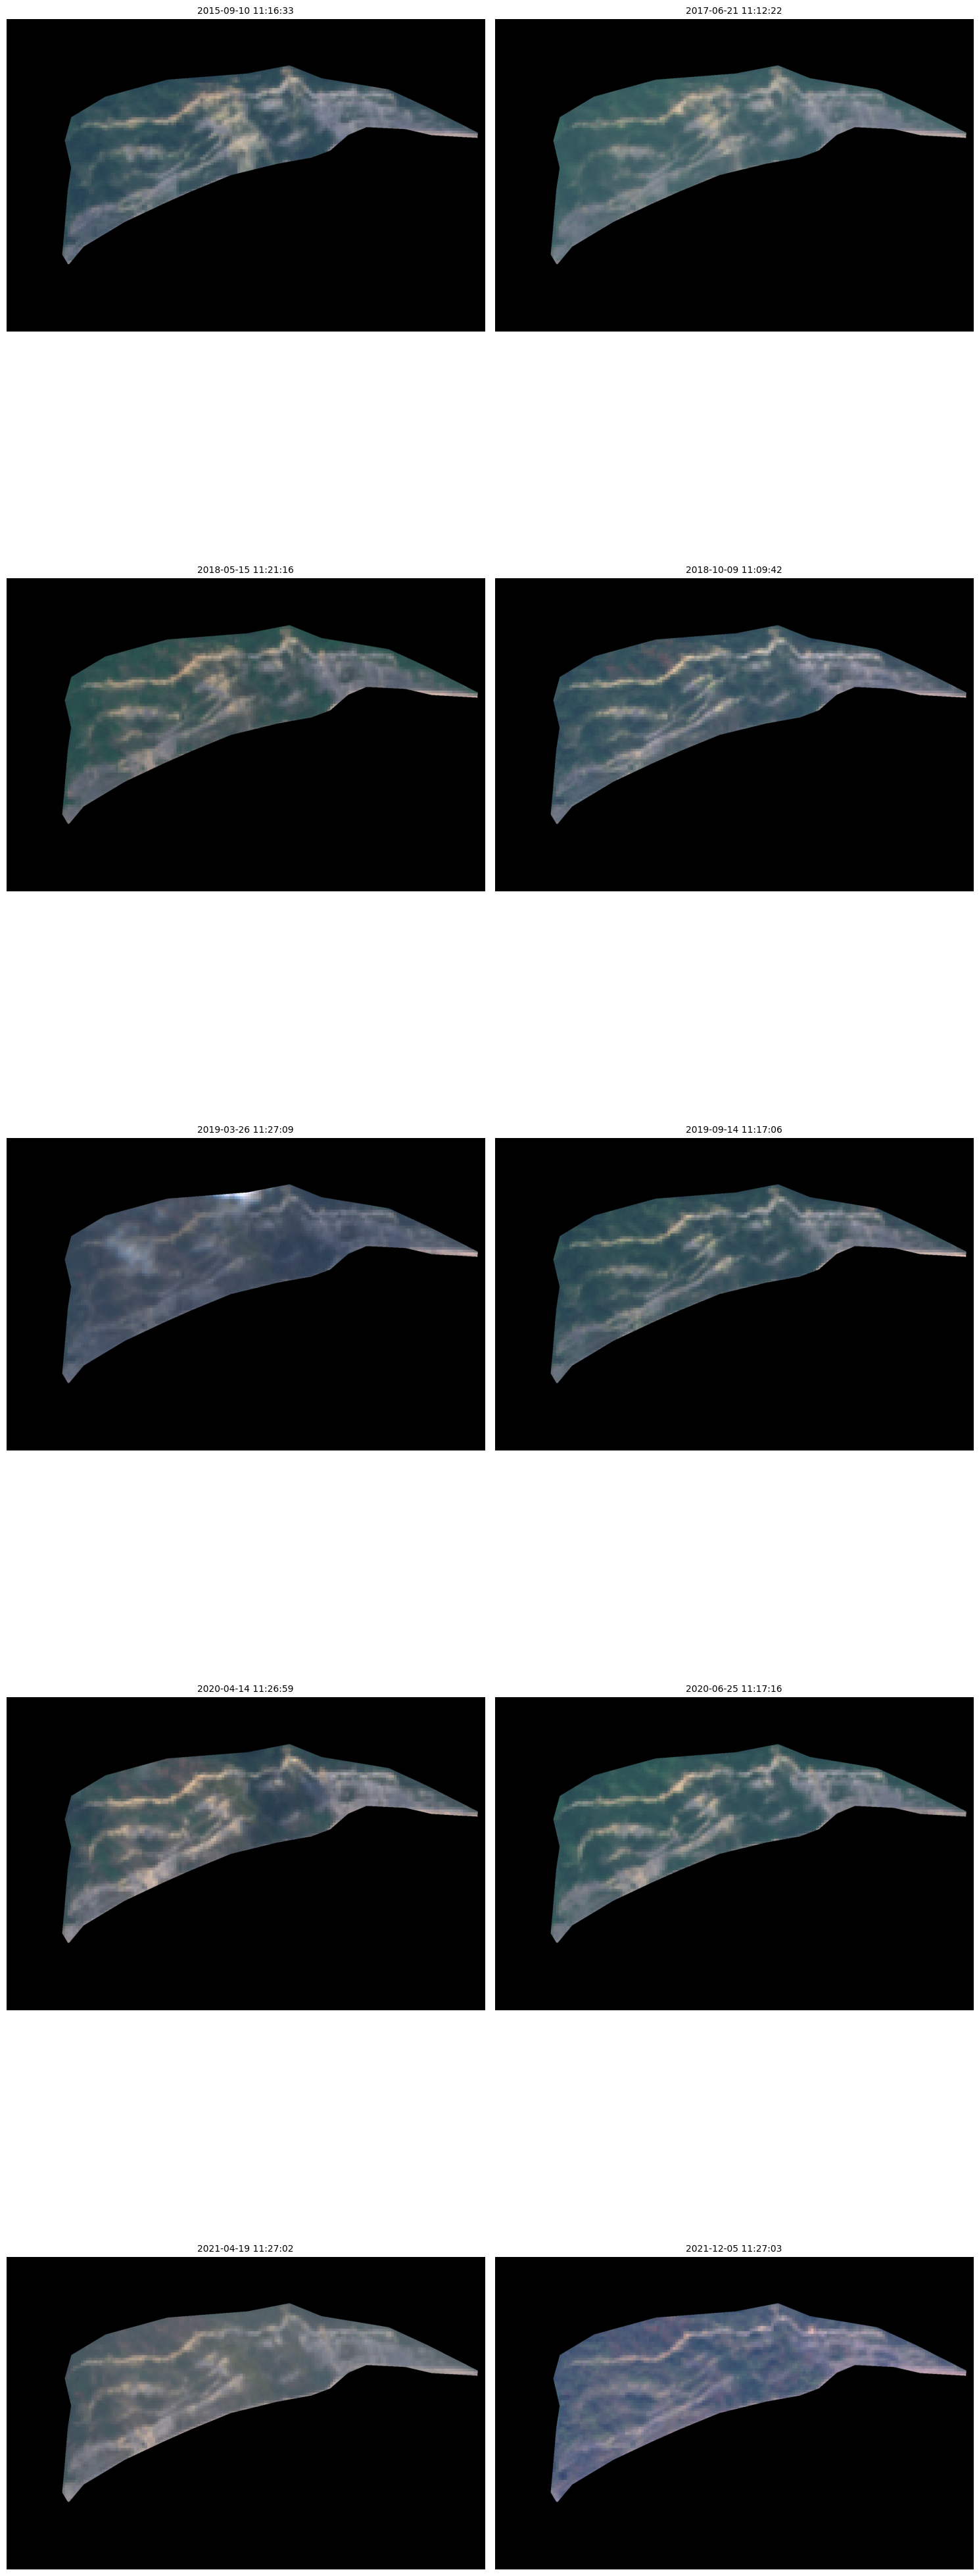

In [ ]:
ncols, nrows = 2, 5

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 45), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)
id = np.arange(0, 100, 10)
for idx in range(10):

    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(masked_df["all_bands"][id[idx]][:,:,[2,1,0]]*0.0001*3.5, 0, 1))
    ax.set_title(masked_df["date"][id[idx]], fontsize=10)

plt.tight_layout()

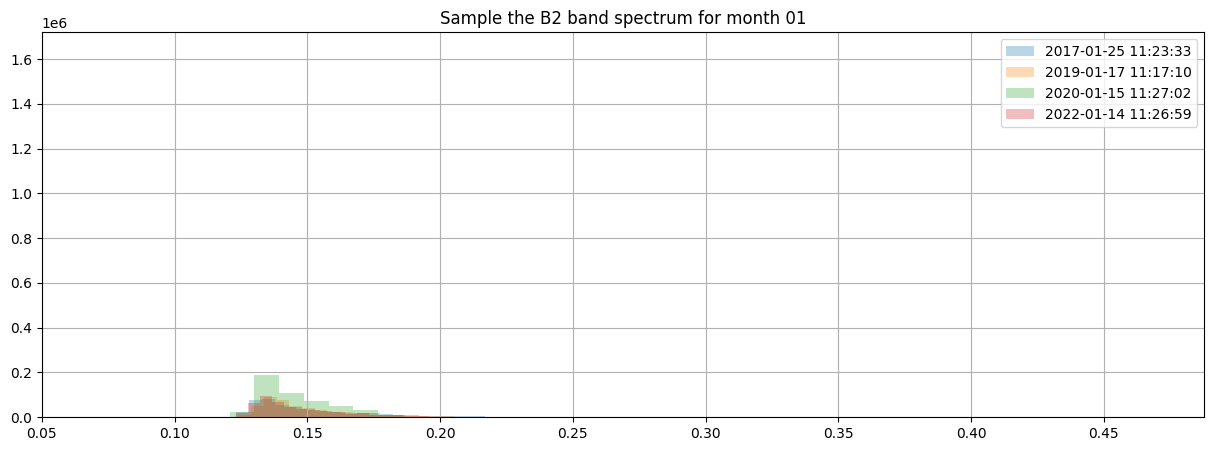

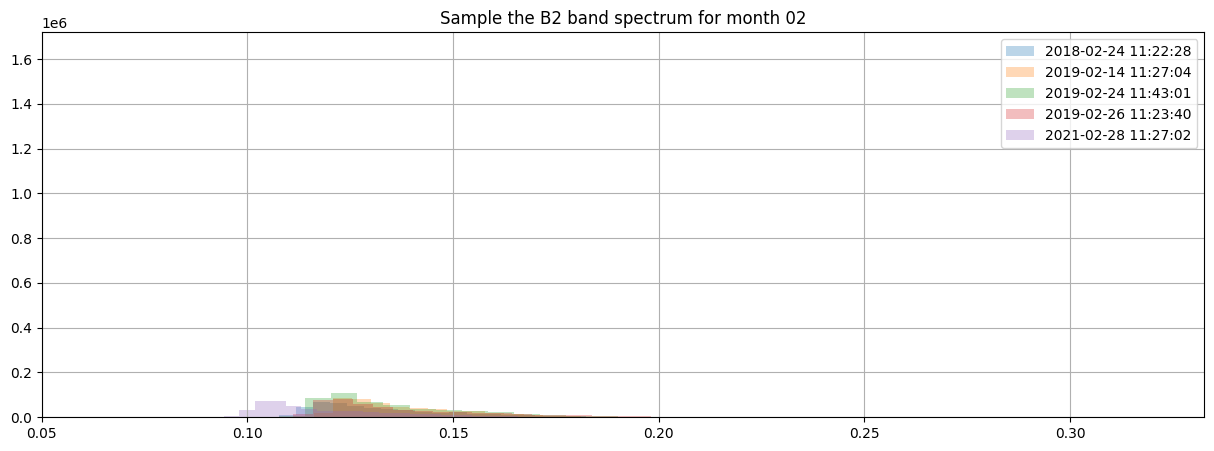

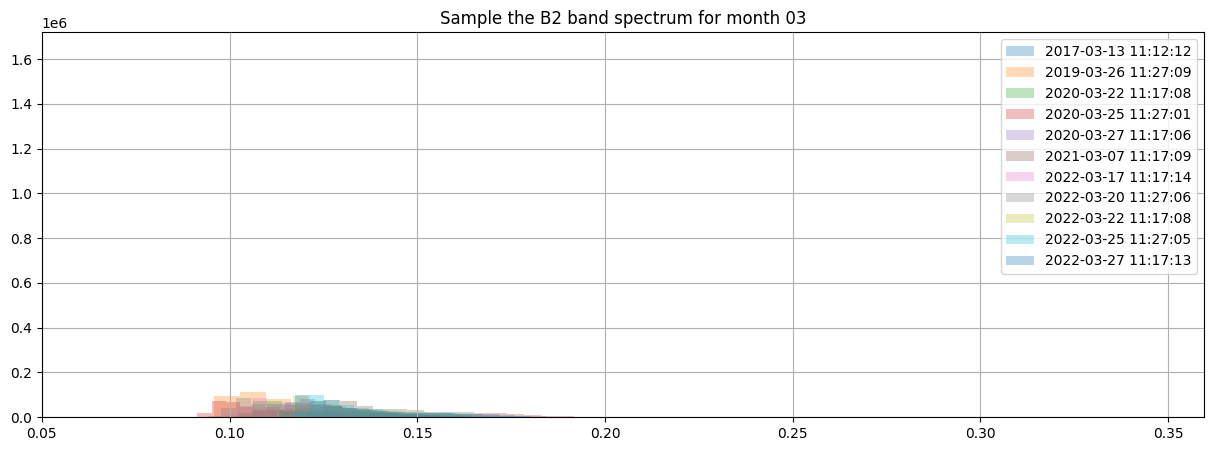

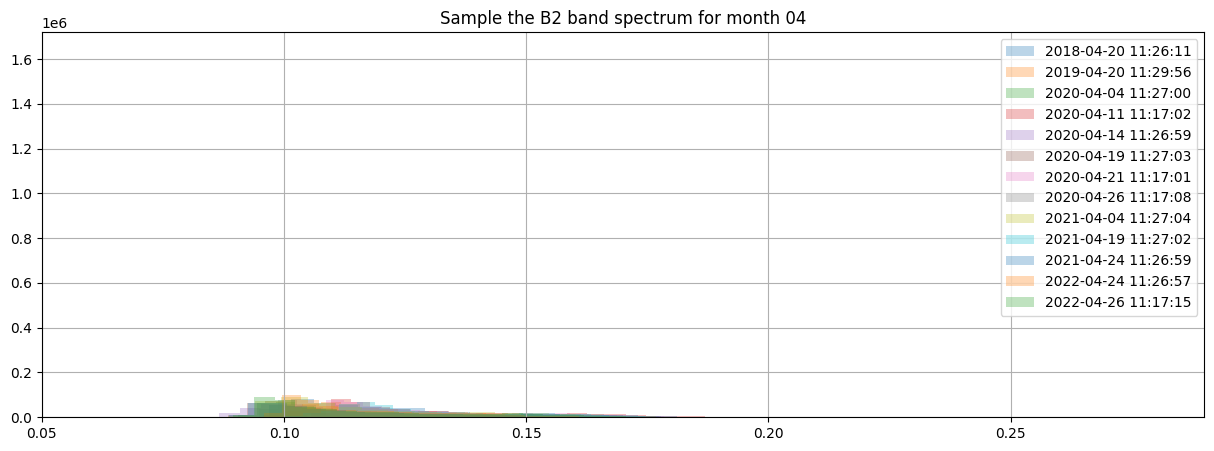

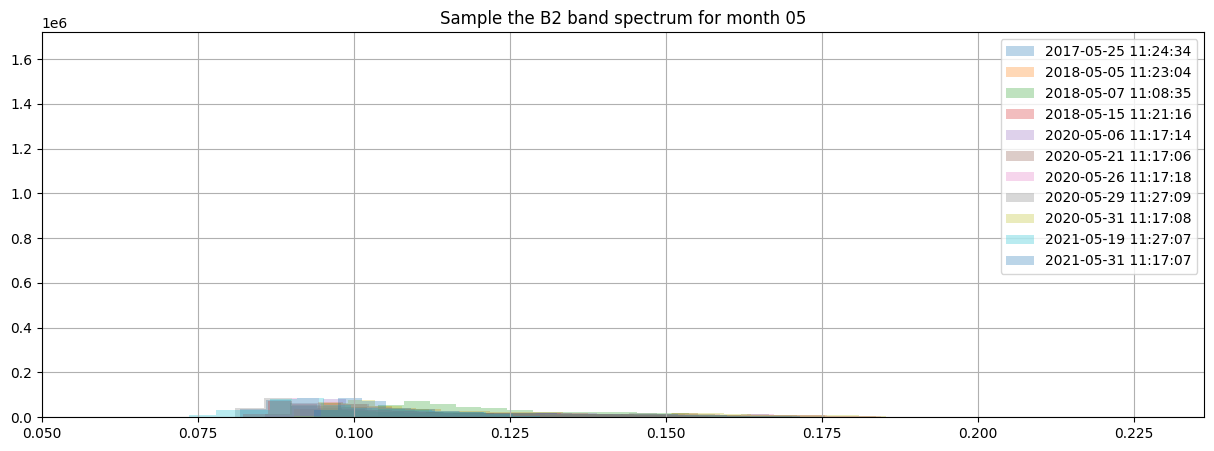

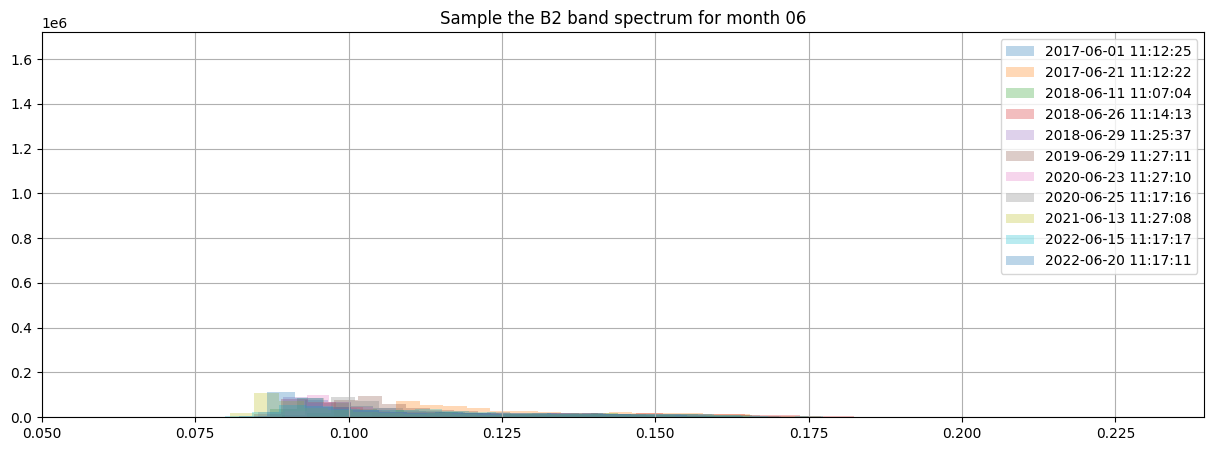

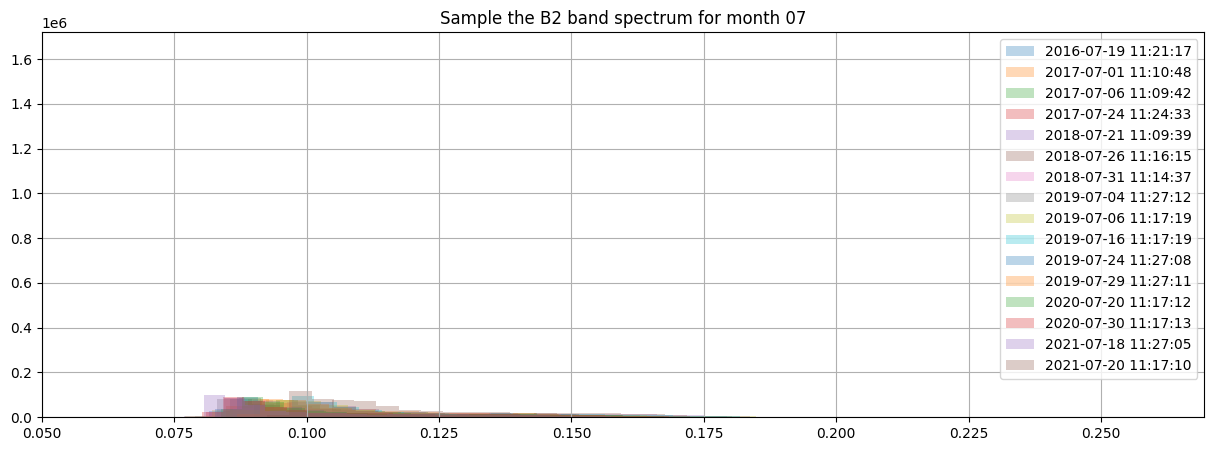

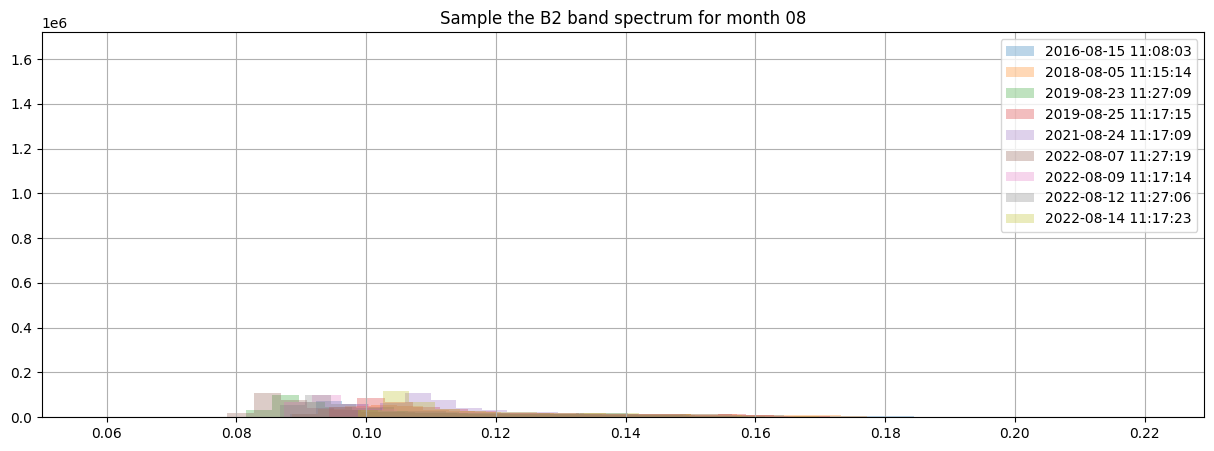

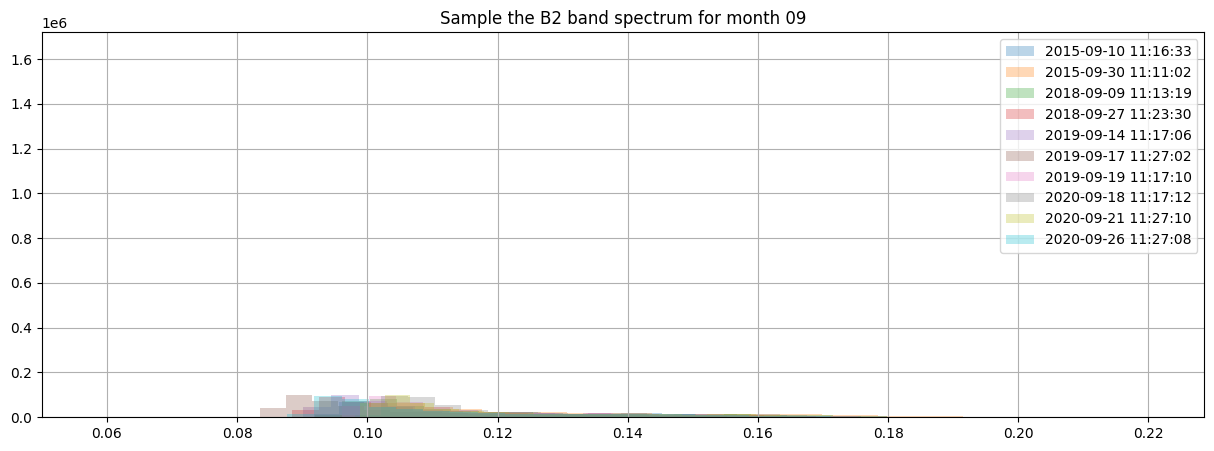

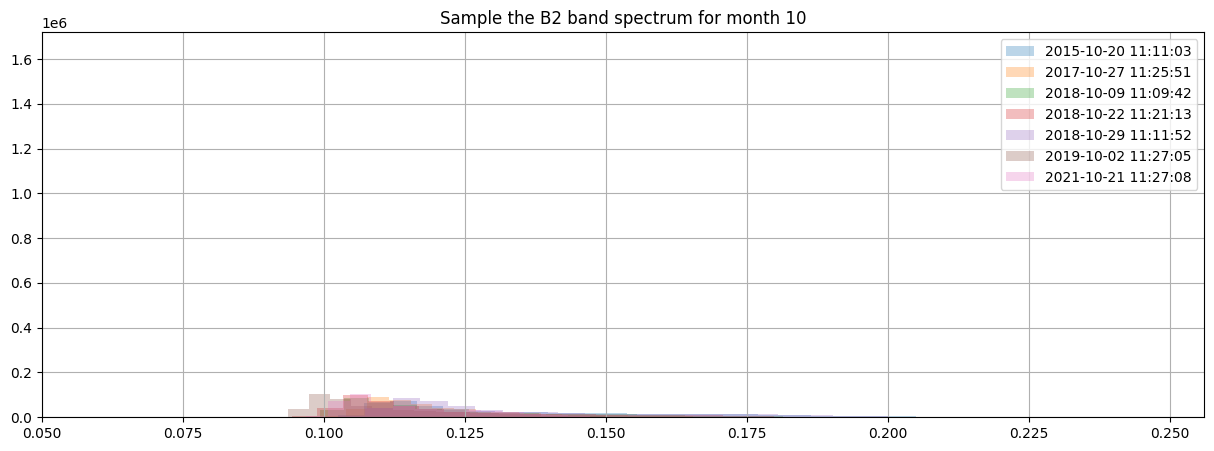

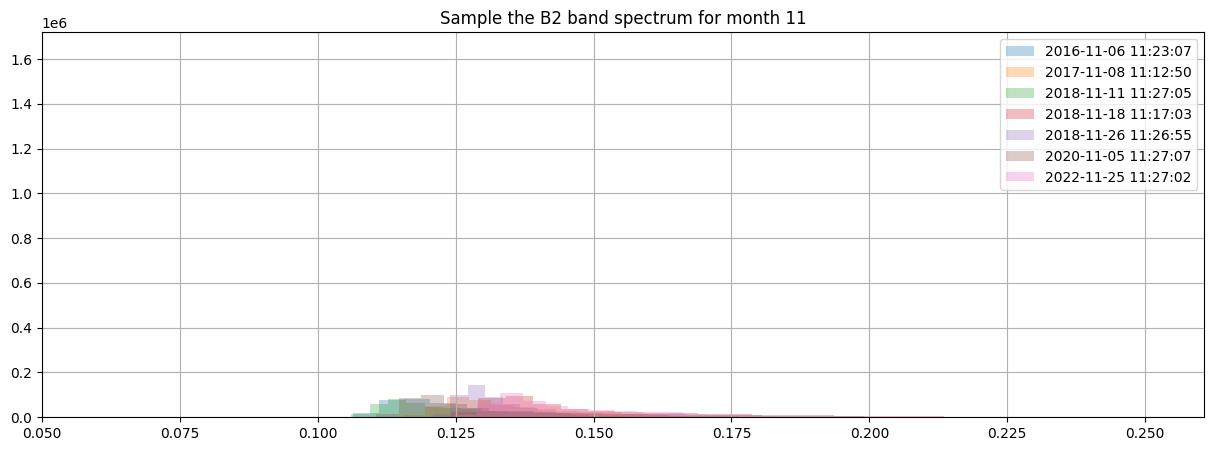

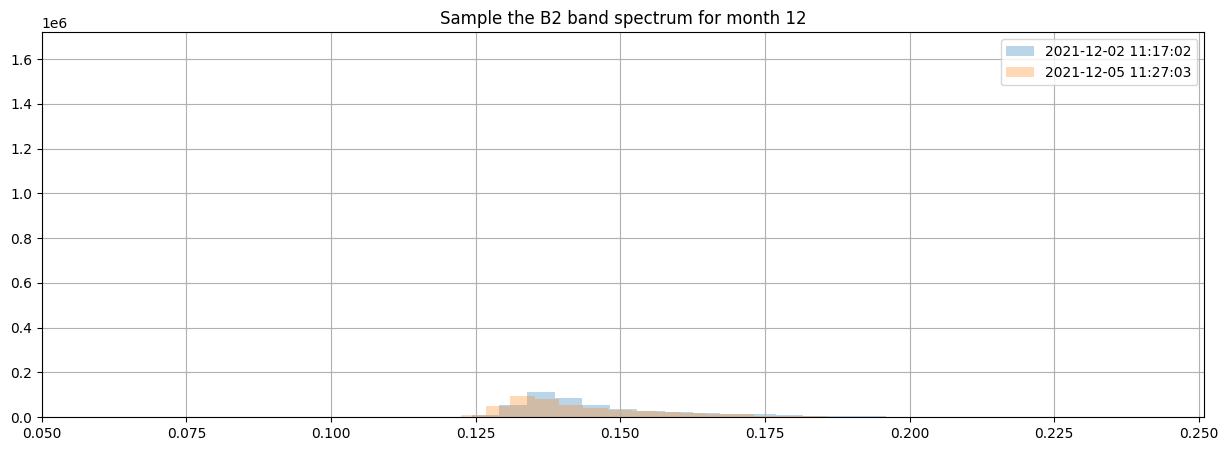

In [ ]:
# Filter for specific single month for each year
month_lst = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for m in month_lst:
  df2 = masked_df[masked_df['date'].dt.strftime('%m') == m]
  # Possible other bands to explore - B2, B3, B4, B8 and B11
  band_id = "B2"
  _, ax = plt.subplots(figsize=(15, 5))

  for i, rows in df2.iterrows():
    plt.hist(np.clip(rows[band_id].flatten()*0.0001,0,1), bins=50, label=f"{rows['date']}", alpha=0.3)

  ax.grid("on")
  ax.set_xlim(0.05)
  ax.legend()
  plt.title(f"Sample the {band_id} band spectrum for month {m}")
  plt.show()

In [ ]:
stats_mask_df = create_stats_df(masked_df)
stats_mask_df.head()

,date,B2,B3,B4,B8,B11
0,2015-09-10 11:16:33,0.028000,0.025843,0.021276,0.055816,0.040315
1,2015-09-30 11:11:02,0.029839,0.028144,0.023940,0.063750,0.047857
2,2015-10-20 11:11:03,0.031451,0.028910,0.025286,0.062848,0.050357
3,2016-07-19 11:21:17,0.026022,0.026167,0.021022,0.067762,0.043546
4,2016-08-15 11:08:03,0.027581,0.026905,0.022098,0.066983,0.043271


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


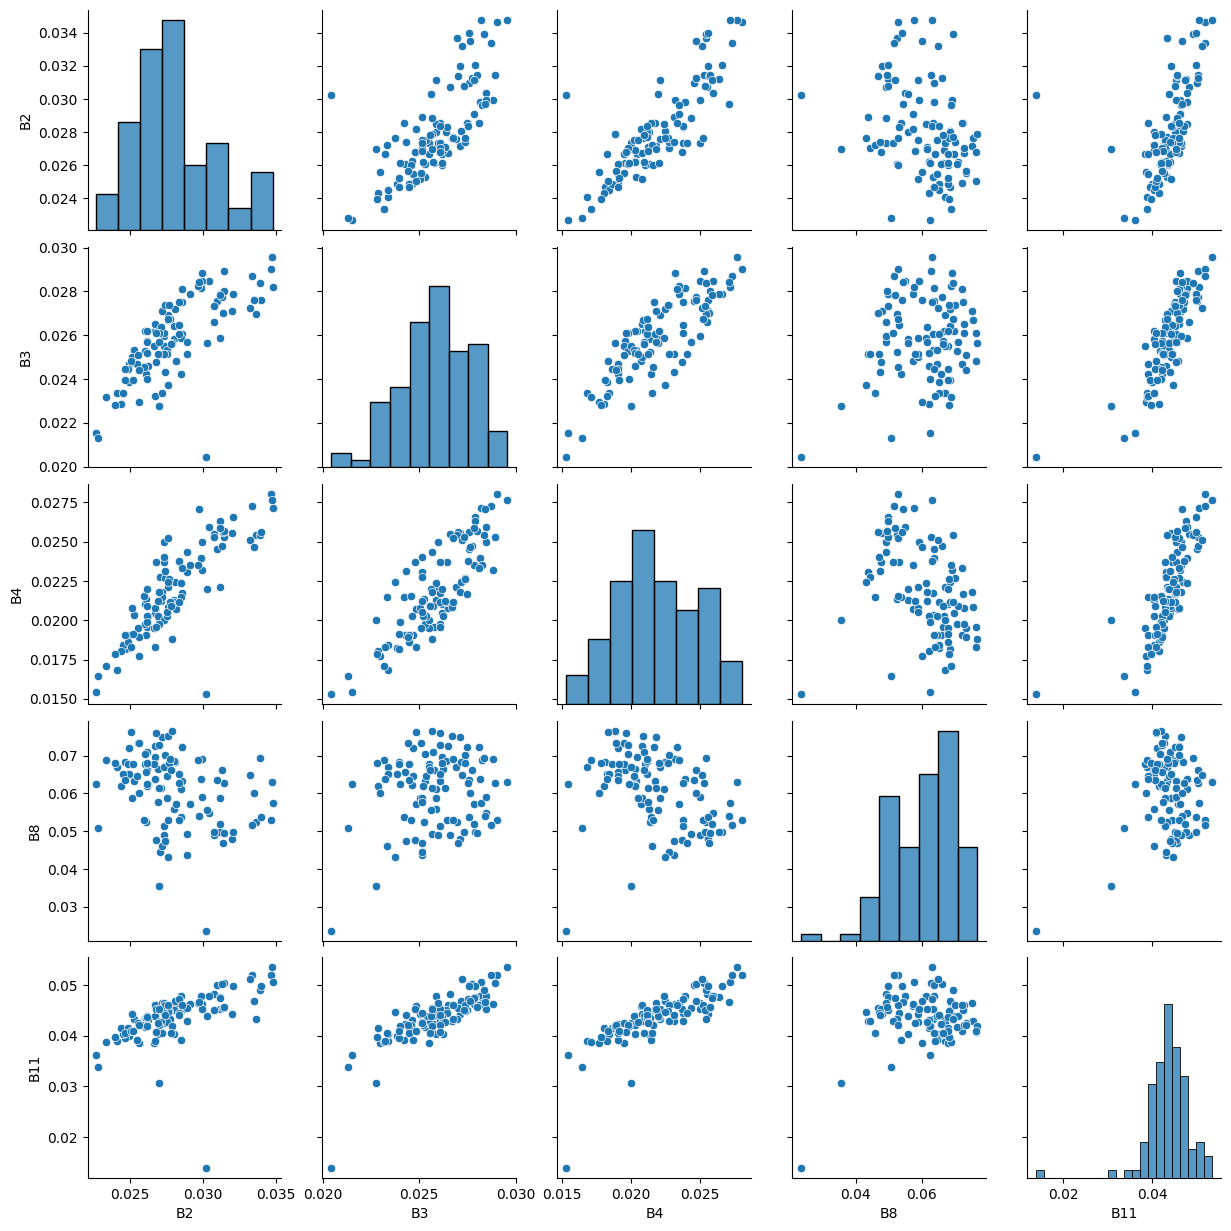

In [ ]:
## Explore the new statistical dataframe
sns.pairplot(stats_mask_df, size=2.5)
plt.savefig("/content/drive/MyDrive/FINAL_project/full_stats_masked_L1C.png")

In [ ]:
## Resample the dataset to give a timeseries of quaterly statisitcs
mask_quat_df = stats_mask_df.resample('Q', on='date').mean()
print(mask_quat_df.head())
print(mask_quat_df.describe())

                  B2        B3        B4        B8       B11
date                                                        
2015-09-30  0.028919  0.026994  0.022608  0.059783  0.044086
2015-12-31  0.031451  0.028910  0.025286  0.062848  0.050357
2016-03-31       NaN       NaN       NaN       NaN       NaN
2016-06-30       NaN       NaN       NaN       NaN       NaN
2016-09-30  0.026802  0.026536  0.021560  0.067373  0.043409
              B2         B3         B4         B8        B11
count  28.000000  28.000000  28.000000  28.000000  28.000000
mean    0.028644   0.026003   0.022184   0.060066   0.044283
std     0.002405   0.001234   0.002415   0.007460   0.002946
min     0.024494   0.022945   0.017556   0.047390   0.038570
25%     0.026528   0.025396   0.020834   0.055130   0.042372
50%     0.028274   0.026286   0.022093   0.060888   0.044119
75%     0.030554   0.026603   0.024597   0.066264   0.045799
max     0.033473   0.028910   0.025579   0.072709   0.050357


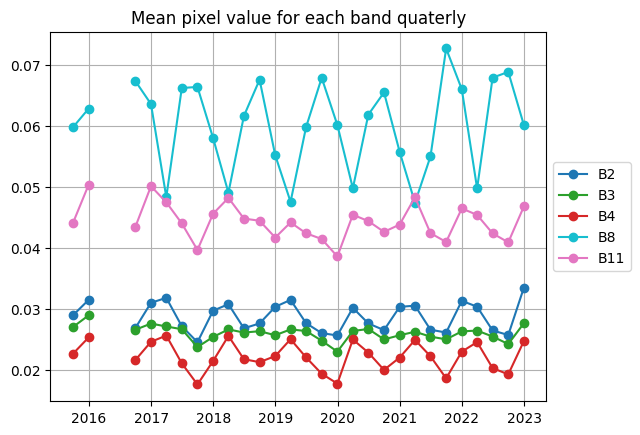

In [ ]:
plot_band_statistics(mask_quat_df)

In [ ]:
stats_mask_df.head()

,date,B2,B3,B4,B8,B11
0,2015-09-10 11:16:33,0.028000,0.025843,0.021276,0.055816,0.040315
1,2015-09-30 11:11:02,0.029839,0.028144,0.023940,0.063750,0.047857
2,2015-10-20 11:11:03,0.031451,0.028910,0.025286,0.062848,0.050357
3,2016-07-19 11:21:17,0.026022,0.026167,0.021022,0.067762,0.043546
4,2016-08-15 11:08:03,0.027581,0.026905,0.022098,0.066983,0.043271


In [ ]:
img_out_path = "/content/drive/MyDrive/FINAL_project/masked_norm_L1C_png"

for index, row in masked_df.iterrows():
    image = np.clip(row["all_bands"][:,:,[2,1,0]]*0.0001*3.5, 0, 1)
    data = im.fromarray(np.uint8(image*255))
    output_path = os.path.join(img_out_path, row["productID"]+".png")
    data.save(output_path)

### Data processing - histogram matching and coregistering imagery

In [4]:

image_path = "/content/drive/MyDrive/FINAL_project/masked_norm_hm_L1C_png"

list_file = []

for f in os.listdir(image_path):
  date_id = f.rsplit("_", 1)[1].rsplit(".", 1)[0].rsplit("T", 1)[0]
  list_file.append((date(int(date_id[:4]), int(date_id[4:6]), int(date_id[6:])), f))

# Sort the list by date
sorted_files = sorted(list_file, key=lambda x: x[0], reverse=True)
print(sorted_files[2])

(datetime.date(2022, 8, 12), 'histm_S2B_MSIL1C_20220812T112119_N0400_R037_T30UWB_20220812T120820.png')


In [ ]:
### Histogram matching ####
histogram_matched = []
outfolder_path = "/content/drive/MyDrive/FINAL_project/masked_norm_hm_L1C_png"

#Base image
img = cv2.imread(os.path.join(image_path, sorted_files[2][1]))
base_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for t in range(len(sorted_files)):
    img2 = cv2.imread(os.path.join(image_path, sorted_files[t][1]))
    rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    matched = match_histograms(rgb2, base_image, channel_axis=-1)
    histogram_matched.append([sorted_files[t][0], matched])
    img_data = im.fromarray(matched)
    output_path = os.path.join(outfolder_path, "histm_"+sorted_files[t][1])
    img_data.save(output_path)

In [ ]:
## Compare the histogram matching results
def plot_result_comparison(source, reference, result, save_flag=False, filename="", output_dir="./"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                        sharex=True, sharey=True)
    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()

    ax1.imshow(source)
    ax1.set_title('Source')
    ax2.imshow(reference)
    ax2.set_title('Reference')
    ax3.imshow(result)
    ax3.set_title('Matched')

    plt.tight_layout()
    if save_flag:
        plt.savefig(os.path.join(output_dir, f"histc_match_{filename}.png"))
    plt.show()


In [ ]:
img = cv2.imread(os.path.join(image_path, sorted_files[2][1]))
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
histogram_output = "/content/drive/MyDrive/FINAL_project/histogram_comp_L1C"

for i, img in enumerate(sorted_files):
    img2 = cv2.imread(os.path.join(image_path, img[1]))
    rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plot_result_comparison(rgb2, rgb, histogram_matched[i][1], True, img[1].rsplit(".")[0], histogram_output)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_hist_comparison(source, reference, result, save_flag=False, filename="", output_dir="./"):

    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
    sourcef = source[:,:,0].flatten()
    referencef = reference[:,:,0].flatten()
    resultf = result[:,:,0].flatten()
    # Excluding the color black as this is the masked out area
    axs[0].hist(sourcef[sourcef > 0], bins=100)
    axs[1].hist(referencef[referencef > 0], bins=100)
    axs[2].hist(resultf[resultf > 0], bins=100)

    plt.show()

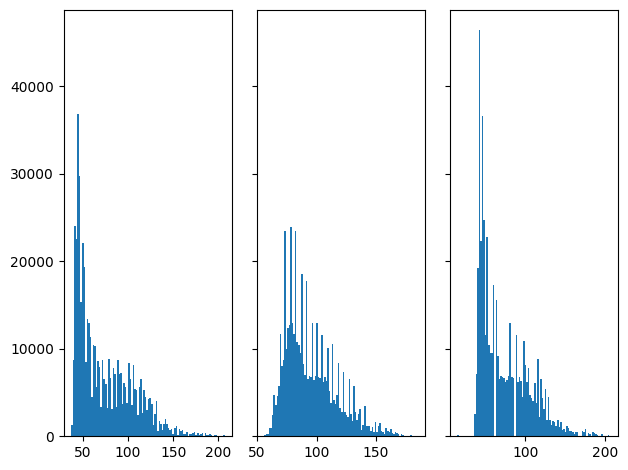

In [ ]:
## Sampling histograms before/after histogram matching
img2 = cv2.imread(os.path.join(image_path, sorted_files[0][1]))
rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plot_hist_comparison(rgb, rgb2, histogram_matched[0][1])

In [5]:
### Coregistrastion ####

# Assign the base image
img1 = cv2.imread(os.path.join(image_path, sorted_files[-1][1]))
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
output_path = os.path.join("/content/drive/MyDrive/FINAL_project/masked_norm_hm_coreg_L1C_png", f"aligned_{sorted_files[-1][1]}")
cv2.imwrite(output_path, img1)

for i in range(len(sorted_files)):

    img2 = cv2.imread(os.path.join(image_path, sorted_files[i][1]))
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500, 0.001)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    try:
        (cc, warp_matrix) = cv2.findTransformECC(gray1, gray2, warp_matrix, cv2.MOTION_EUCLIDEAN, criteria)

        # Find size of image1
        size1 = gray1.shape

        # Align the images
        aligned_image = cv2.warpAffine(img2, warp_matrix, (size1[1], size1[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        # Save the aligned image
        output_path = os.path.join("/content/drive/MyDrive/FINAL_project/masked_norm_hm_coreg_L1C_png", f"aligned_{sorted_files[i][1]}")
        cv2.imwrite(output_path, aligned_image)

    except:
      print(f"Image {i} did not converge")